<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [106]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
df = pd.read_csv(url8)

In [107]:
df=pd.DataFrame(df)
#df.rename(columns = {'Average Wind Speed (m/s)':'avg_wind_speed'}, inplace = True)
df

,Date & Time,Average Wind Speed (m/s)
0,8/1/2021,10.66
1,8/1/2021 0:10,10.71
2,8/1/2021 0:20,10.53
3,8/1/2021 0:30,10.20
4,8/1/2021 0:40,10.34
...,...,...
4404,8/31/2021 23:20,11.62
4405,8/31/2021 23:30,11.16
4406,8/31/2021 23:40,10.66
4407,8/31/2021 23:50,10.90


In [108]:
df['Date & Time'][0]="8/1/2021 0:00"
df['Date & Time'][4408]="9/1/2021  0:00"
df


,Date & Time,Average Wind Speed (m/s)
0,8/1/2021 0:00,10.66
1,8/1/2021 0:10,10.71
2,8/1/2021 0:20,10.53
3,8/1/2021 0:30,10.20
4,8/1/2021 0:40,10.34
...,...,...
4404,8/31/2021 23:20,11.62
4405,8/31/2021 23:30,11.16
4406,8/31/2021 23:40,10.66
4407,8/31/2021 23:50,10.90


In [109]:
df.describe()

,Average Wind Speed (m/s)
count,"4,409.00"
mean,9.95
std,2.59
min,1.81
25%,8.22
50%,10.06
75%,11.88
max,16.45


# **Train, validation and test sets**
We separate our dataset into train, validation and test sets.

In [110]:
train,valid,test=df[:4209],df[4209:4309],df[4309:4409]  #seperate train and test data arrays
print(train.shape)
print(valid.shape)
print(test.shape)

print(train.describe())
print(valid.describe())
print(test.describe())

(4209, 2)
(100, 2)
(100, 2)
       Average Wind Speed (m/s)
count                  4,209.00
mean                       9.96
std                        2.63
min                        1.81
25%                        8.15
50%                       10.10
75%                       11.92
max                       16.45
       Average Wind Speed (m/s)
count                    100.00
mean                       9.23
std                        1.09
min                        7.13
25%                        8.34
50%                        9.07
75%                       10.14
max                       11.31
       Average Wind Speed (m/s)
count                    100.00
mean                      10.57
std                        1.25
min                        8.68
25%                        9.25
50%                       10.59
75%                       11.86
max                       12.50


In [111]:
fig = px.line(df, x="Date & Time" , y="Average Wind Speed (m/s)") 
fig.show()

In [112]:
train

,Date & Time,Average Wind Speed (m/s)
0,8/1/2021 0:00,10.66
1,8/1/2021 0:10,10.71
2,8/1/2021 0:20,10.53
3,8/1/2021 0:30,10.20
4,8/1/2021 0:40,10.34
...,...,...
4204,8/30/2021 14:00,9.95
4205,8/30/2021 14:10,10.46
4206,8/30/2021 14:20,10.24
4207,8/30/2021 14:30,10.15


In [113]:
#date_time = pd.to_datetime(df_new['Date & Time'], format='%m/%d/%Y %H:%M')

# **Data preparation - training data**

In [114]:
T = 10
HORIZON = 1

**Scale the time series within [0,1]**

In [115]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train=pd.DataFrame(train["Average Wind Speed (m/s)"])
train["Average Wind Speed (m/s)"] = scaler.fit_transform(train)
train.head(10)

,Average Wind Speed (m/s)
0,0.60
1,0.61
2,0.60
3,0.57
4,0.58
5,0.59
6,0.60
7,0.62
8,0.62
9,0.61



**Original vs scaled data:**

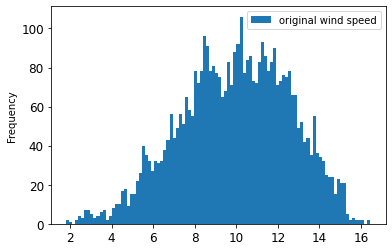

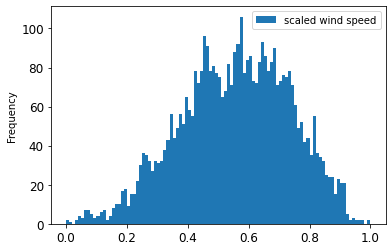

In [116]:
df[df.index < 4210][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":'original wind speed'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={"Average Wind Speed (m/s)":'scaled wind speed'}).plot.hist(bins=100, fontsize=12)
plt.show()

**Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example**

In [117]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted["Average Wind Speed (m/s)"].shift(-1)
train_shifted.head(10)

,Average Wind Speed (m/s),y_t+1
0,0.60,0.61
1,0.61,0.60
2,0.60,0.57
3,0.57,0.58
4,0.58,0.59
5,0.59,0.60
6,0.60,0.62
7,0.62,0.62
8,0.62,0.61
9,0.61,0.61


In [118]:
for t in range(1, T+1):
    train_shifted['wind_speed_t-'+str(T-t)] = train_shifted["Average Wind Speed (m/s)"].shift(T-t)
train_shifted = train_shifted.rename(columns={"Average Wind Speed (m/s)":'Original_wind_speed'})
train_shifted.head(10)

,Original_wind_speed,y_t+1,wind_speed_t-9,wind_speed_t-8,wind_speed_t-7,wind_speed_t-6,wind_speed_t-5,wind_speed_t-4,wind_speed_t-3,wind_speed_t-2,wind_speed_t-1,wind_speed_t-0
0,0.60,0.61,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.60
1,0.61,0.60,nan,nan,nan,nan,nan,nan,nan,nan,0.60,0.61
2,0.60,0.57,nan,nan,nan,nan,nan,nan,nan,0.60,0.61,0.60
3,0.57,0.58,nan,nan,nan,nan,nan,nan,0.60,0.61,0.60,0.57
4,0.58,0.59,nan,nan,nan,nan,nan,0.60,0.61,0.60,0.57,0.58
5,0.59,0.60,nan,nan,nan,nan,0.60,0.61,0.60,0.57,0.58,0.59
6,0.60,0.62,nan,nan,nan,0.60,0.61,0.60,0.57,0.58,0.59,0.60
7,0.62,0.62,nan,nan,0.60,0.61,0.60,0.57,0.58,0.59,0.60,0.62
8,0.62,0.61,nan,0.60,0.61,0.60,0.57,0.58,0.59,0.60,0.62,0.62
9,0.61,0.61,0.60,0.61,0.60,0.57,0.58,0.59,0.60,0.62,0.62,0.61


In [119]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,Original_wind_speed,y_t+1,wind_speed_t-9,wind_speed_t-8,wind_speed_t-7,wind_speed_t-6,wind_speed_t-5,wind_speed_t-4,wind_speed_t-3,wind_speed_t-2,wind_speed_t-1,wind_speed_t-0
9,0.61,0.61,0.60,0.61,0.60,0.57,0.58,0.59,0.60,0.62,0.62,0.61
10,0.61,0.61,0.61,0.60,0.57,0.58,0.59,0.60,0.62,0.62,0.61,0.61
11,0.61,0.63,0.60,0.57,0.58,0.59,0.60,0.62,0.62,0.61,0.61,0.61
12,0.63,0.65,0.57,0.58,0.59,0.60,0.62,0.62,0.61,0.61,0.61,0.63
13,0.65,0.66,0.58,0.59,0.60,0.62,0.62,0.61,0.61,0.61,0.63,0.65


**Convert the target variable into a numpy array(vector format)**

In [120]:
y_train = np.array(train_shifted[["y_t+1"]])

In [121]:
y_train.shape

(4199, 1)

In [122]:
y_train[:3]

array([[0.61],
       [0.61],
       [0.63]])

**Convert the inputs into a numpy array with shape (samples, time steps, features)**

In [123]:
X_train=np.array(train_shifted[['wind_speed_t-'+str(T-t) for t in range(1, T+1)]])
X_train = X_train[... , np.newaxis]


In [124]:
X_train.shape

(4199, 10, 1)

In [125]:
X_train[:3]

array([[[0.6 ],
        [0.61],
        [0.6 ],
        [0.57],
        [0.58],
        [0.59],
        [0.6 ],
        [0.62],
        [0.62],
        [0.61]],

       [[0.61],
        [0.6 ],
        [0.57],
        [0.58],
        [0.59],
        [0.6 ],
        [0.62],
        [0.62],
        [0.61],
        [0.61]],

       [[0.6 ],
        [0.57],
        [0.58],
        [0.59],
        [0.6 ],
        [0.62],
        [0.62],
        [0.61],
        [0.61],
        [0.61]]])

# **Data preparation - validation set**

In [126]:
valid=pd.DataFrame(valid["Average Wind Speed (m/s)"])
valid

,Average Wind Speed (m/s)
4209,9.67
4210,9.38
4211,9.16
4212,8.99
4213,9.27
...,...
4304,8.18
4305,8.01
4306,8.10
4307,8.43


In [127]:
valid_new=df[4209-T+1:4309]
valid_new=pd.DataFrame(valid_new["Average Wind Speed (m/s)"])
valid_new.head(20)

,Average Wind Speed (m/s)
4200,7.88
4201,8.50
4202,8.75
4203,9.13
4204,9.95
4205,10.46
4206,10.24
4207,10.15
4208,10.15
4209,9.67


In [128]:
valid_new['Average Wind Speed (m/s)']=scaler.transform(valid_new)
valid_new.head()

,Average Wind Speed (m/s)
4200,0.41
4201,0.46
4202,0.47
4203,0.50
4204,0.56


In [129]:
valid_shifted = valid_new.copy()
valid_shifted['y_t+1'] = valid_shifted["Average Wind Speed (m/s)"].shift(-1)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['wind_speed_t-'+str(T-t)] = valid_shifted["Average Wind Speed (m/s)"].shift(T-t)
vali_shifted = valid_shifted.rename(columns={"Average Wind Speed (m/s)":'Original_wind_speed'})

valid_shifted = valid_shifted.dropna(how='any')
y_valid = np.array(valid_shifted[["y_t+1"]])
X_valid=np.array(valid_shifted[['wind_speed_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid[... , np.newaxis]

In [130]:
y_valid.shape

(99, 1)

In [131]:
X_valid.shape

(99, 10, 1)

# **Implement the Convolutional Neural Network**
We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

In [132]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [133]:
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [134]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [135]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 10, 5)             15        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten_2 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


Use Adam optimizer and mean squared error as the loss function.

In [136]:
model.compile(optimizer='Adam', loss='mse')

In [137]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [138]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [139]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
132/132 [==============================] - 1s 4ms/step - loss: 0.0792 - val_loss: 0.0038
Epoch 2/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 3/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 4/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 5/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 6/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 7/10
132/132 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 8/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0010

Load the model with the smallest mape

In [140]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

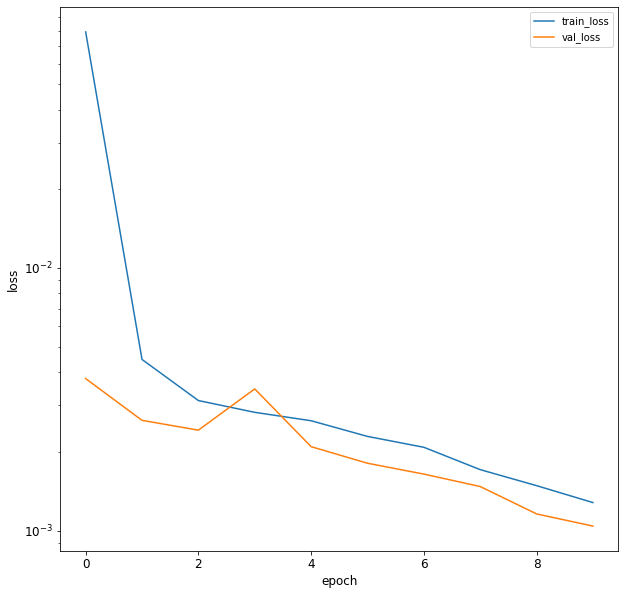

In [141]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# **Evaluate the model** 

**Create the test set**

In [142]:
test=pd.DataFrame(test["Average Wind Speed (m/s)"])
test

,Average Wind Speed (m/s)
4309,8.68
4310,8.96
4311,9.25
4312,9.25
4313,9.03
...,...
4404,11.62
4405,11.16
4406,10.66
4407,10.90


In [143]:
test_new=df[4309-T+1:4409]
test_new=pd.DataFrame(test_new["Average Wind Speed (m/s)"])
test_new.head(20)

,Average Wind Speed (m/s)
4300,8.33
4301,8.26
4302,8.37
4303,8.38
4304,8.18
4305,8.01
4306,8.10
4307,8.43
4308,8.60
4309,8.68


**Scale tht test data**

In [144]:
test_new['Average Wind Speed (m/s)']=scaler.transform(test_new)
test_new.head()

,Average Wind Speed (m/s)
4300,0.45
4301,0.44
4302,0.45
4303,0.45
4304,0.44


**Create test set features**

In [145]:
test_shifted = test_new.copy()
test_shifted['y_t+1'] = test_shifted["Average Wind Speed (m/s)"].shift(-1)
print(test_shifted)

for t in range(1, T+1):
    test_shifted['wind_speed_t-'+str(T-t)] = test_shifted["Average Wind Speed (m/s)"].shift(T-t)
test_shifted = test_shifted.rename(columns={"Average Wind Speed (m/s)":'Original_wind_speed'})

test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted[["y_t+1"]])
X_test=np.array(test_shifted[['wind_speed_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test[... , np.newaxis]

      Average Wind Speed (m/s)  y_t+1
4300                      0.45   0.44
4301                      0.44   0.45
4302                      0.45   0.45
4303                      0.45   0.44
4304                      0.44   0.42
...                        ...    ...
4404                      0.67   0.64
4405                      0.64   0.60
4406                      0.60   0.62
4407                      0.62   0.62
4408                      0.62    nan

[109 rows x 2 columns]


**Make predictions on test set**

In [146]:
predictions = model.predict(X_test)
predictions

array([[0.46],
       [0.47],
       [0.48],
       [0.49],
       [0.49],
       [0.5 ],
       [0.5 ],
       [0.49],
       [0.49],
       [0.49],
       [0.49],
       [0.49],
       [0.5 ],
       [0.51],
       [0.52],
       [0.52],
       [0.54],
       [0.55],
       [0.55],
       [0.55],
       [0.56],
       [0.55],
       [0.55],
       [0.55],
       [0.55],
       [0.56],
       [0.56],
       [0.56],
       [0.56],
       [0.56],
       [0.56],
       [0.56],
       [0.55],
       [0.54],
       [0.53],
       [0.53],
       [0.52],
       [0.52],
       [0.51],
       [0.51],
       [0.51],
       [0.51],
       [0.51],
       [0.5 ],
       [0.5 ],
       [0.5 ],
       [0.5 ],
       [0.52],
       [0.53],
       [0.55],
       [0.57],
       [0.59],
       [0.6 ],
       [0.62],
       [0.63],
       [0.64],
       [0.64],
       [0.64],
       [0.65],
       [0.65],
       [0.65],
       [0.66],
       [0.67],
       [0.68],
       [0.69],
       [0.69],
       [0.

In [147]:
predictions=pd.DataFrame(predictions)
predictions

,0
0,0.46
1,0.47
2,0.48
3,0.49
4,0.49
...,...
94,0.69
95,0.68
96,0.67
97,0.65


**Compare predictions to actual wind speed**

In [148]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 
eval_df

#eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
#eval_df

,timestamp,h,prediction,actual
0,4309,t+1,0.46,0.49
1,4310,t+1,0.47,0.51
2,4311,t+1,0.48,0.51
3,4312,t+1,0.49,0.49
4,4313,t+1,0.49,0.50
...,...,...,...,...
94,4403,t+1,0.69,0.67
95,4404,t+1,0.68,0.64
96,4405,t+1,0.67,0.60
97,4406,t+1,0.65,0.62


In [149]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

3.9844663950344783

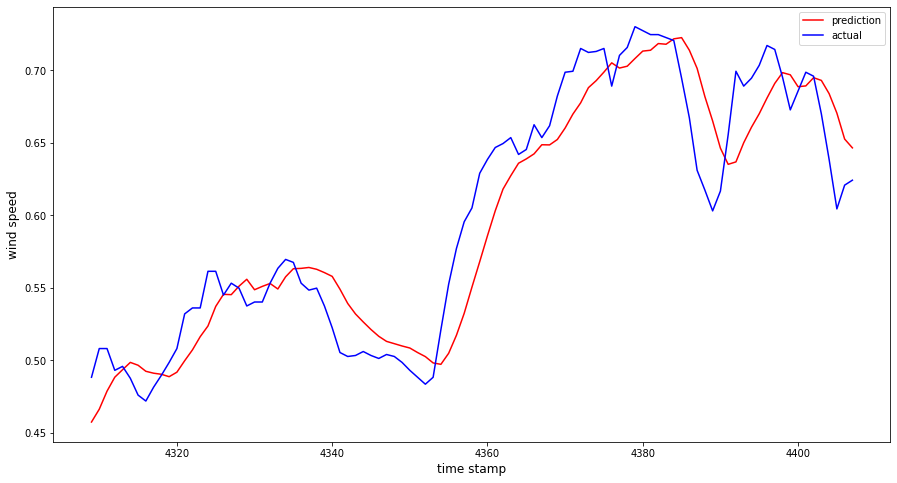

In [150]:
eval_df[eval_df.timestamp<4408].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('time stamp', fontsize=12)
plt.ylabel('wind speed', fontsize=12)
plt.show()

**Clean up model files**

In [152]:
for m in glob('model_*.h5'):
    os.remove(m)